In [4]:
# This code is for comparing the difference between AI generated paths, human navigated paths, and the actual shortest path

import pandas as pd
import networkx as nx
import os
import csv
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.spatial.distance import cosine
from sentence_transformers import SentenceTransformer
from src.data.paths_loader import load_ai_paths, load_human_paths
from src.utils.evaluation_utils import get_shortest_path, embedding_distance, calculate_closeness_scores, rank_neighbors, calculate_rank_of_neighbors, calculate_target_scores, score_filtering, compute_path_degrees


# load the links file
df = pd.read_csv('data/wikispeedia_paths-and-graph/links.tsv', sep='\t', comment='#', header=None, names=['origin', 'destination'])

# Create a directed graph
G = nx.from_pandas_edgelist(df, source='origin', target='destination', create_using=nx.DiGraph())

# load the origin and destination pairs, in the first column
ori_dest = pd.read_csv('data/ori_dest.csv').iloc[:, 0].tolist()
ori_dest = [eval(pair) for pair in ori_dest]

In [8]:
# for each pair, load the AI generated path and the human navigated path
AI_paths = load_ai_paths('data/paths', ori_dest)
improved_ai_paths = load_ai_paths('data/paths_improved_prompt', ori_dest)
human_paths = load_human_paths(ori_dest)
shortest_paths = get_shortest_path(G, ori_dest)

In [21]:
# print the average path length for each pair
for pair in ori_dest:
    start_article, target_article = pair
    ai_path = AI_paths[pair]
    human_path = human_paths[pair]
    shortest_path = shortest_paths[pair]
    # calculat the mean path length
    ai_path_len = sum([len(path) for path in ai_path]) / len(ai_path) if ai_path else 0
    improved_ai_path_len = sum([len(path) for path in improved_ai_paths[pair]]) / len(improved_ai_paths[pair]) if improved_ai_paths[pair] else 0
    human_path_len = sum([len(path) for path in human_path]) / len(human_path) if human_path else 0
    shortest_path_len = len(shortest_path[0]) if shortest_path else 0
    print(f"Start: {start_article}, Target: {target_article}")
    print(f"AI path length: {ai_path_len}, improved AI path length: {improved_ai_path_len}, Human path length: {human_path_len}, Shortest path length: {shortest_path_len}")


Start: Brain, Target: Telephone
AI path length: 5.6, improved AI path length: 5.0, Human path length: 7.1, Shortest path length: 4
Start: Theatre, Target: Zebra
AI path length: 8.6, improved AI path length: 10.75, Human path length: 7.83646408839779, Shortest path length: 4
Start: Pyramid, Target: Bean
AI path length: 5.6, improved AI path length: 5.0, Human path length: 8.246105919003115, Shortest path length: 4
Start: Batman, Target: Wood
AI path length: 7.5, improved AI path length: 5.8, Human path length: 7.263513513513513, Shortest path length: 4
Start: Bird, Target: Great_white_shark
AI path length: 9.6, improved AI path length: 10.0, Human path length: 5.695652173913044, Shortest path length: 4
Start: Batman, Target: The_Holocaust
AI path length: 5.4, improved AI path length: 6.0, Human path length: 5.420168067226891, Shortest path length: 4
Start: Bird, Target: Adolf_Hitler
AI path length: 5.0, improved AI path length: 4.0, Human path length: 5.401869158878505, Shortest path le

f:\Anaconda\envs\ada2\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
f:\Anaconda\envs\ada2\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


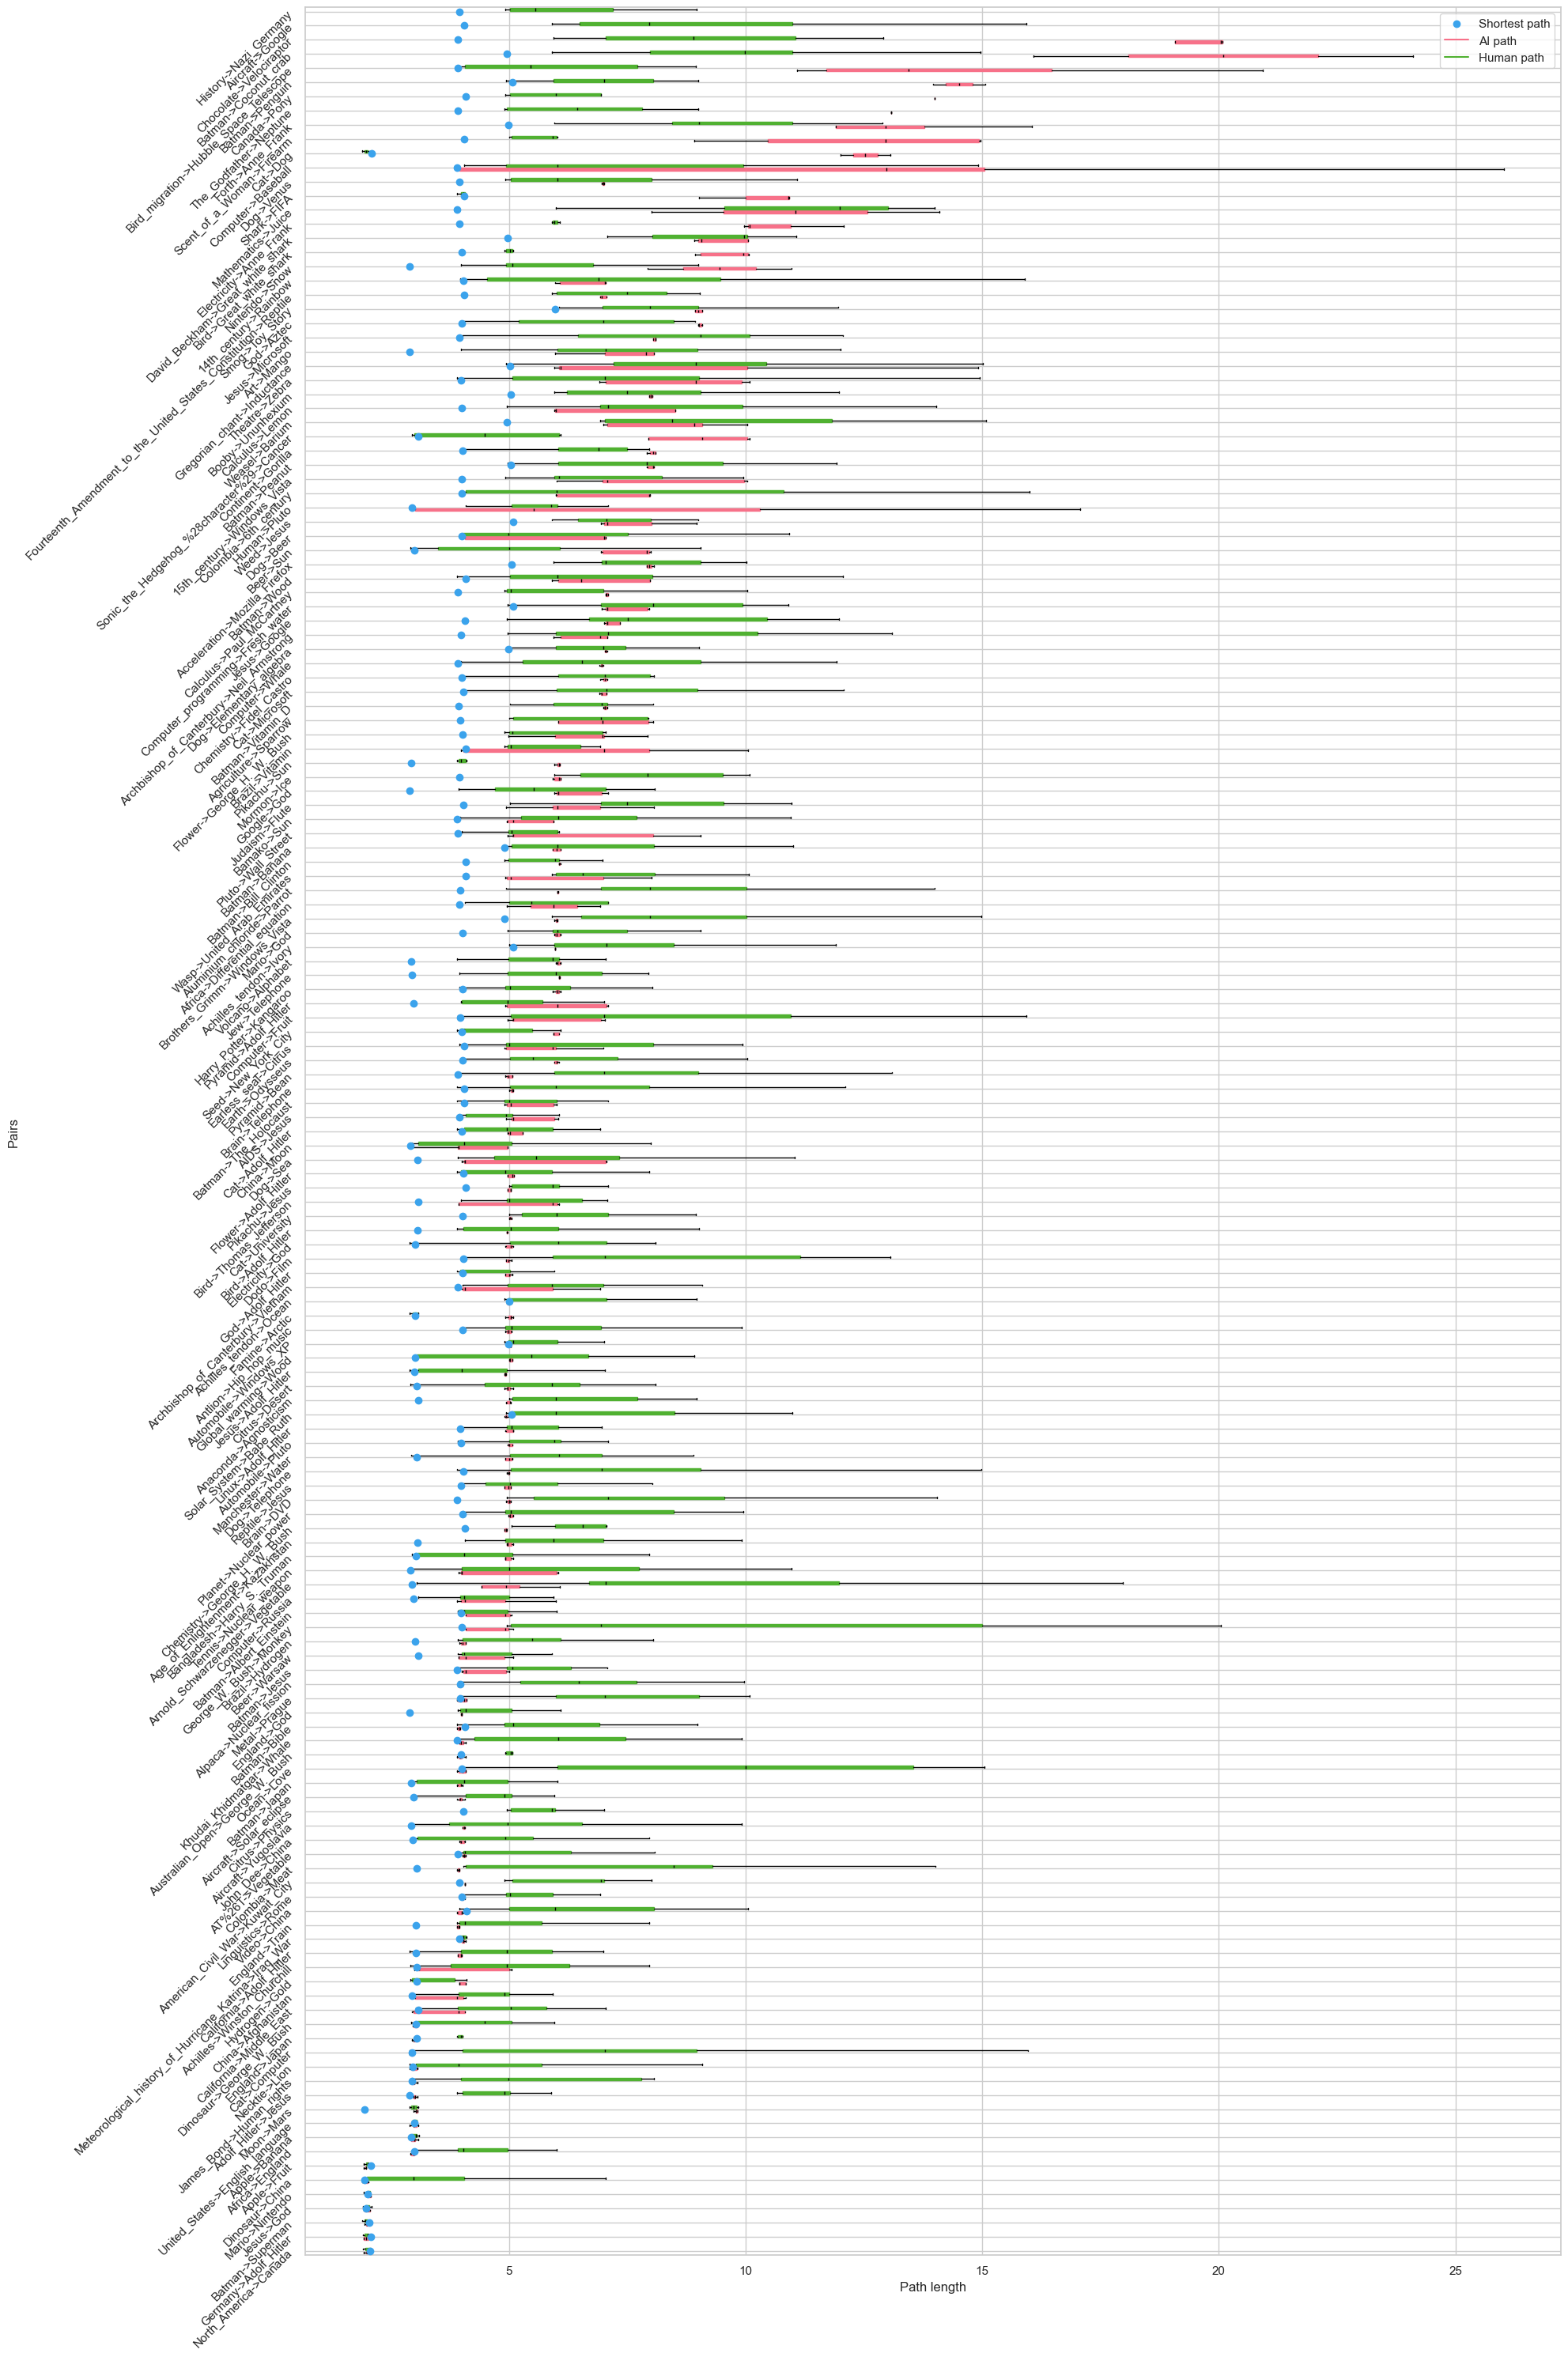

In [10]:
# the x-axis is the path length, the y-axis is the pairs

ai_path_len = [[len(path) for path in AI_paths[pair]] for pair in ori_dest]
improved_ai_paths_len = [[len(path) for path in improved_ai_paths[pair]] for pair in ori_dest]
human_path_len = [[len(path) for path in human_paths[pair]] for pair in ori_dest]
shortest_path_len = [[len(shortest_paths[pair][0])] for pair in ori_dest]

# Calculate mean values of AI path lengths and sort pairs based on these means
mean_ai_path_len = [np.mean(lengths) for lengths in ai_path_len]
sorted_indices = np.argsort(mean_ai_path_len)
sorted_ori_dest = [ori_dest[i] for i in sorted_indices]
sorted_ai_path_len = [ai_path_len[i] for i in sorted_indices]
sorted_improved_ai_path_len = [improved_ai_paths_len[i] for i in sorted_indices]
sorted_human_path_len = [human_path_len[i] for i in sorted_indices]
sorted_shortest_path_len = [shortest_path_len[i] for i in sorted_indices]

# Set the style and color palette
sns.set(style="whitegrid")
palette = sns.color_palette("husl", 3)

# Adjust the figure size to lengthen the graph
plt.figure(figsize=(20, 30))

# Add jitter to the boxplot
def add_jitter(data, jitter_amount=0.1):
    return data + np.random.uniform(-jitter_amount, jitter_amount, size=len(data))

jittered_ai_path_len = [add_jitter(lengths) for lengths in sorted_ai_path_len]
# jittered_improved_ai_path_len = [add_jitter(lengths) for lengths in sorted_improved_ai_path_len]
jittered_human_path_len = [add_jitter(lengths) for lengths in sorted_human_path_len]
jittered_shortest_path_len = [add_jitter(lengths) for lengths in sorted_shortest_path_len]

# Plot AI and human paths in the same line for each pair
positions = np.array(range(len(sorted_ori_dest))) * 3.0
plt.boxplot(jittered_ai_path_len, positions=positions - 0.4, sym='', widths=0.6, vert=False, patch_artist=True,
            boxprops=dict(facecolor=palette[0], color=palette[0]),
            medianprops=dict(color='black'))
plt.boxplot(jittered_human_path_len, positions=positions + 0.4, sym='', widths=0.6, vert=False, patch_artist=True,
            boxprops=dict(facecolor=palette[1], color=palette[1]),
            medianprops=dict(color='black'))

# Plot shortest paths
plt.scatter(jittered_shortest_path_len, positions, color=palette[2], label='Shortest path', zorder=3)

# Create dummy plots for the legend
plt.plot([], [], color=palette[0], label='AI path')
plt.plot([], [], color=palette[1], label='Human path')

plt.yticks(positions, [f"{pair[0]}->{pair[1]}" for pair in sorted_ori_dest], rotation=45, ha='right')
plt.xlabel("Path length")
plt.ylabel("Pairs")
plt.legend()
plt.tight_layout()
plt.show()

In [11]:
# Get Sentence embedding
model = SentenceTransformer('all-MiniLM-L6-v2')
sentence_embeddings = {node: model.encode(node.replace('_', ' ')) for node in G.nodes}

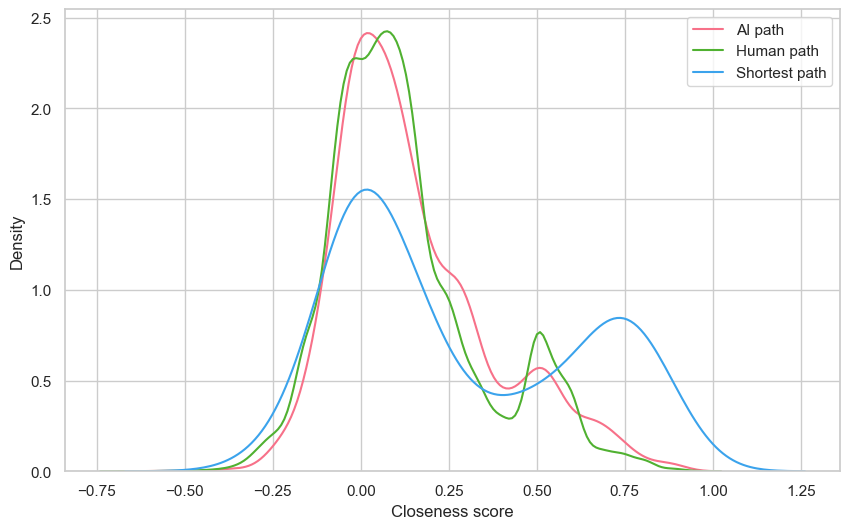

In [12]:
# Calculate closeness scores for AI paths and human paths
ai_closeness_scores = {}
human_closeness_scores = {}
optimal_closeness_scores = {}
ai_target_scores = {}
human_target_scores = {}

for pair in ori_dest:
    start_article, target_article = pair
    ai_path = AI_paths[pair]
    human_path = human_paths[pair]
    ai_closeness_scores[pair] = [calculate_closeness_scores(path, sentence_embeddings) for path in ai_path]
    human_closeness_scores[pair] = [calculate_closeness_scores(path, sentence_embeddings) for path in human_path]
    optimal_closeness_scores[pair] = [calculate_closeness_scores(path, sentence_embeddings) for path in shortest_paths[pair]]
    ai_target_scores[pair] = [calculate_target_scores(path, sentence_embeddings) for path in ai_path]
    human_target_scores[pair] = [calculate_target_scores(path, sentence_embeddings) for path in human_path]


# Plot to show the difference in closeness scores distribution between AI paths and human paths
plt.figure(figsize=(10, 6))
ai_scores = [score for pair in ori_dest for score in ai_closeness_scores[pair]]
human_scores = [score for pair in ori_dest for score in human_closeness_scores[pair]]
optimal_scores = [score for pair in ori_dest for score in optimal_closeness_scores[pair]]
ai_scores = [score for sublist in ai_scores for score in sublist]
human_scores = [score for sublist in human_scores for score in sublist]
optimal_scores = [score for sublist in optimal_scores for score in sublist]
sns.kdeplot(ai_scores, label='AI path', color=palette[0])
sns.kdeplot(human_scores, label='Human path', color=palette[1])
sns.kdeplot(optimal_scores, label='Shortest path', color=palette[2])
plt.xlabel("Closeness score")
plt.ylabel("Density")
plt.legend()
plt.show()

In [13]:
# Calculate rank of neighbors for AI paths and human paths
ai_rank_scores = {}
human_rank_scores = {}
optimal_rank_scores = {}
for pair in ori_dest:
    start_article, target_article = pair
    ai_path = AI_paths[pair]
    human_path = human_paths[pair]
    ai_rank_scores[pair] = [calculate_rank_of_neighbors(path, G, sentence_embeddings) for path in ai_path]
    human_rank_scores[pair] = [calculate_rank_of_neighbors(path, G, sentence_embeddings) for path in human_path]
    optimal_rank_scores[pair] = [calculate_rank_of_neighbors(path, G, sentence_embeddings) for path in shortest_paths[pair]]

# Plot to show the difference in rank of neighbors distribution between AI paths and human paths
plt.figure(figsize=(10, 6))
ai_scores = [score for pair in ori_dest for score in ai_rank_scores[pair]]
human_scores = [score for pair in ori_dest for score in human_rank_scores[pair]]
optimal_scores = [score for pair in ori_dest for score in optimal_rank_scores[pair]]
ai_scores = np.array([score for sublist in ai_scores for score in sublist])
human_scores = np.array([score for sublist in human_scores for score in sublist])
optimal_scores = np.array([score for sublist in optimal_scores for score in sublist])


# some are not in links like Wikipedia_Text_of_the_GNU_Free_Documentation_License

Node Wikipedia_Text_of_the_GNU_Free_Documentation_License is not in the neighbors of Programming_language
Node Wikipedia_Text_of_the_GNU_Free_Documentation_License is not in the graph
Node Wikipedia_Text_of_the_GNU_Free_Documentation_License is not in the neighbors of Bird
Node Wikipedia_Text_of_the_GNU_Free_Documentation_License is not in the graph
Node Wikipedia_Text_of_the_GNU_Free_Documentation_License is not in the neighbors of Cat
Node Wikipedia_Text_of_the_GNU_Free_Documentation_License is not in the graph
Node %C3%85land is not in the neighbors of Finland
Node Functional_programming is not in the neighbors of Functional_programming
Node Unix is not in the neighbors of Programming_language
Node GNU is not in the neighbors of Linux
Node Internet is not in the neighbors of Linux
Node Season is not in the neighbors of Internet
Node Bioinformatics is not in the neighbors of Programming_language
Node Fourteenth_Amendment_to_the_United_States_Constitution is not in the neighbors of Cr

<Figure size 1000x600 with 0 Axes>

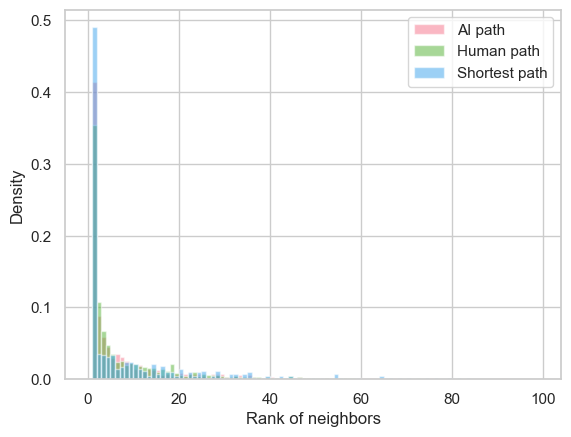

In [14]:
# plot the distribution of the rank of neighbors for AI paths and human paths
plt.hist(ai_scores, bins=range(100), alpha=0.5, label='AI path', color=palette[0], density=True)
plt.hist(human_scores, bins=range(100), alpha=0.5, label='Human path', color=palette[1], density=True)
plt.hist(optimal_scores, bins=range(100), alpha=0.5, label='Shortest path', color=palette[2], density=True)
plt.xlabel("Rank of neighbors")
plt.ylabel("Density")
plt.legend()
plt.show()


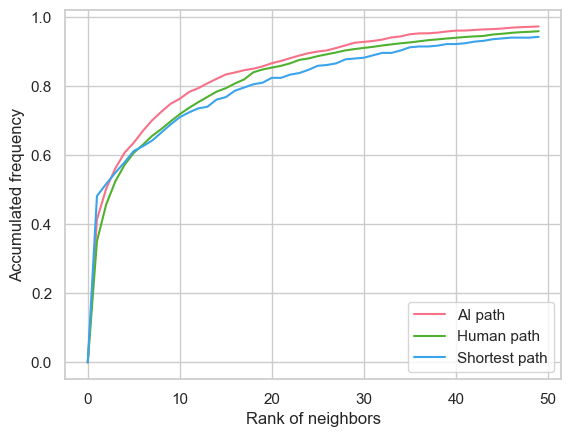

In [15]:
# plot the accumulated distribution of the rank of neighbors for AI paths and human paths simply in a line graph
ai_scores = np.sort(ai_scores)
human_scores = np.sort(human_scores)
optimal_scores = np.sort(optimal_scores)

# calculate the frequency
ai_scores_freq = np.bincount(ai_scores)
human_scores_freq = np.bincount(human_scores)
optimal_scores_freq = np.bincount(optimal_scores)

# calculate the accumulated frequency
ai_scores_accumulated = np.cumsum(ai_scores_freq)/len(ai_scores)
human_scores_accumulated = np.cumsum(human_scores_freq)/len(human_scores)
optimal_scores_accumulated = np.cumsum(optimal_scores_freq)/len(optimal_scores)

# plot the accumulated distribution of the rank of neighbors for AI paths and human paths, only show the first 50 ranks
plt.plot(ai_scores_accumulated[:50], label='AI path', color=palette[0])
plt.plot(human_scores_accumulated[:50], label='Human path', color=palette[1])
plt.plot(optimal_scores_accumulated[:50], label='Shortest path', color=palette[2])
plt.xlabel("Rank of neighbors")
plt.ylabel("Accumulated frequency")
plt.legend()
plt.show()


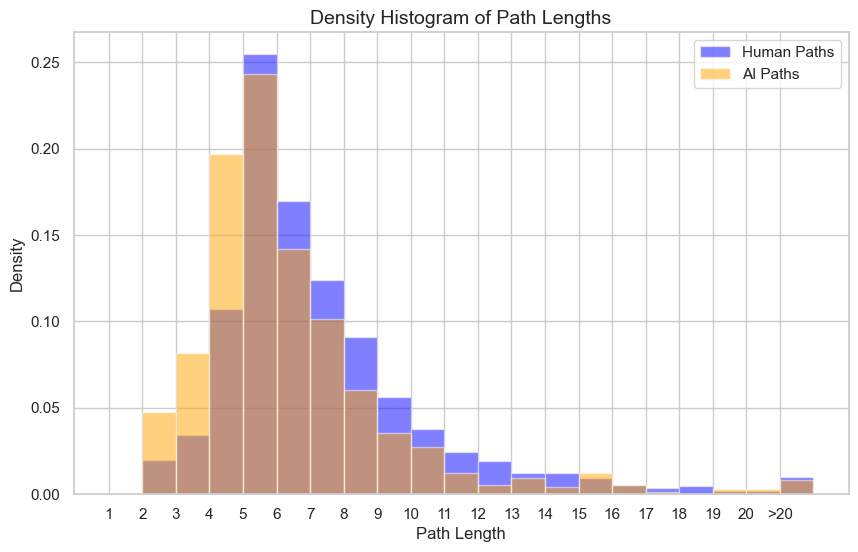

In [16]:
# Path Length distribution Plot
human_lengths_flat = [length for path in human_path_len for length in path]
ai_lengths_flat = [length for path in ai_path_len for length in path]


# Cap the path lengths at 20 and group all lengths >20 into a single bin
human_lengths_capped = [length if length <= 20 else 21 for length in human_lengths_flat]
ai_lengths_capped = [length if length <= 20 else 21 for length in ai_lengths_flat]

# Create the histogram with capped lengths
bins = list(range(1, 22)) + [22]  # Adding a bin for >20
plt.figure(figsize=(10, 6))
plt.hist(human_lengths_capped, bins=bins, alpha=0.5, label="Human Paths", color="blue", density=True)
plt.hist(ai_lengths_capped, bins=bins, alpha=0.5, label="AI Paths", color="orange", density=True)
plt.xticks(range(1, 22), labels=[str(i) for i in range(1, 21)] + ['>20'])
plt.title('Density Histogram of Path Lengths', fontsize=14)
plt.xlabel('Path Length', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend()
plt.show()

In [17]:
filtering_length = 9
first_n = 5

# filtered_ai_scores = score_filtering(ai_closeness_scores, ai_path_len, filtering_length, first_n)
# filtered_human_scores = score_filtering(human_closeness_scores, human_path_len, filtering_length, first_n)
filtered_ai_scores = score_filtering(ai_target_scores, ai_path_len, filtering_length, first_n)
filtered_human_scores = score_filtering(human_target_scores, human_path_len, filtering_length, first_n)

ai_filtered_count = sum(len(list) for list in filtered_ai_scores.values())
human_filtered_count = sum(len(list) for list in filtered_human_scores.values())
ai_filtered_count, human_filtered_count

(93, 1175)

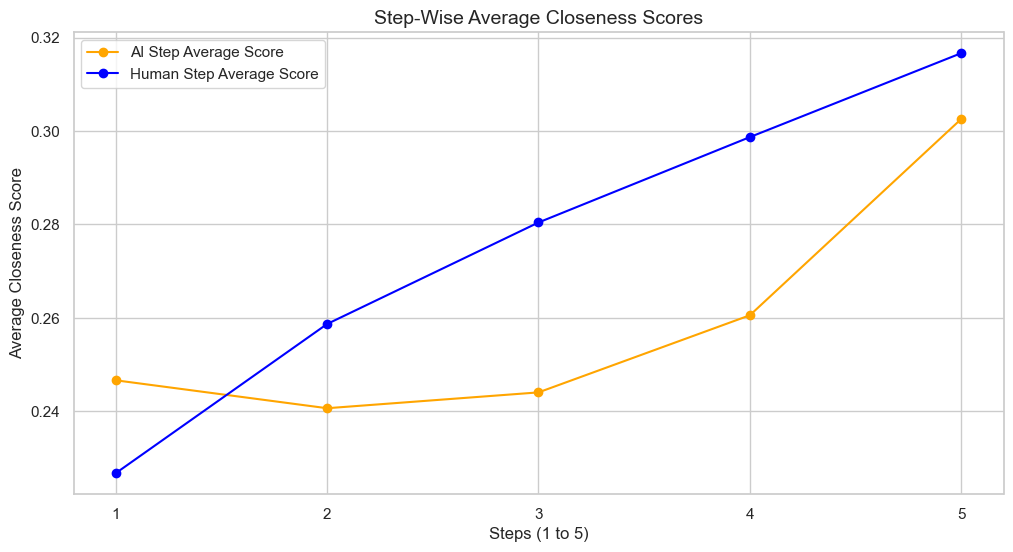

In [18]:
steps = list(range(1, first_n+1))

# Filter out scores that do not match the expected length of 9
filtered_ai_scores_corrected = [
    scores for key, score_lists in filtered_ai_scores.items()
    for scores in score_lists if len(scores) == first_n
]
filtered_human_scores_corrected = [
    scores for key, score_lists in filtered_human_scores.items()
    for scores in score_lists if len(scores) == first_n
]

# Convert filtered scores to NumPy arrays for easier manipulation
ai_scores_array = np.array(filtered_ai_scores_corrected)
human_scores_array = np.array(filtered_human_scores_corrected)
human_scores_array = human_scores_array[~np.isnan(human_scores_array).any(axis=1)]

# Compute average scores for each step
ai_step_avg_scores = ai_scores_array.mean(axis=0)
human_step_avg_scores = human_scores_array.mean(axis=0)

# Plot step-wise average scores
plt.figure(figsize=(12, 6))
plt.plot(steps, ai_step_avg_scores, label='AI Step Average Score', marker='o', color='orange')
plt.plot(steps, human_step_avg_scores, label='Human Step Average Score', marker='o', color='blue')

plt.title('Step-Wise Average Closeness Scores', fontsize=14)
plt.xlabel(f'Steps (1 to {first_n})', fontsize=12)
plt.ylabel('Average Closeness Score', fontsize=12)
plt.xticks(steps)
plt.legend()
plt.show()

In [19]:
# Path Degree Analysis
in_degrees = dict(G.in_degree())  
out_degrees = dict(G.out_degree()) 
total_degrees = {node: in_degrees.get(node, 0) + out_degrees.get(node, 0) for node in set(in_degrees) | set(out_degrees)}

AI_path_degrees = compute_path_degrees(AI_paths, total_degrees)
human_path_degrees = compute_path_degrees(human_paths, total_degrees)

degree_filtering_length = 9
degree_first_n = 5
filtered_ai_degrees = score_filtering(AI_path_degrees, ai_path_len, degree_filtering_length, degree_first_n)
filtered_human_degrees = score_filtering(human_path_degrees, human_path_len, degree_filtering_length, degree_first_n)



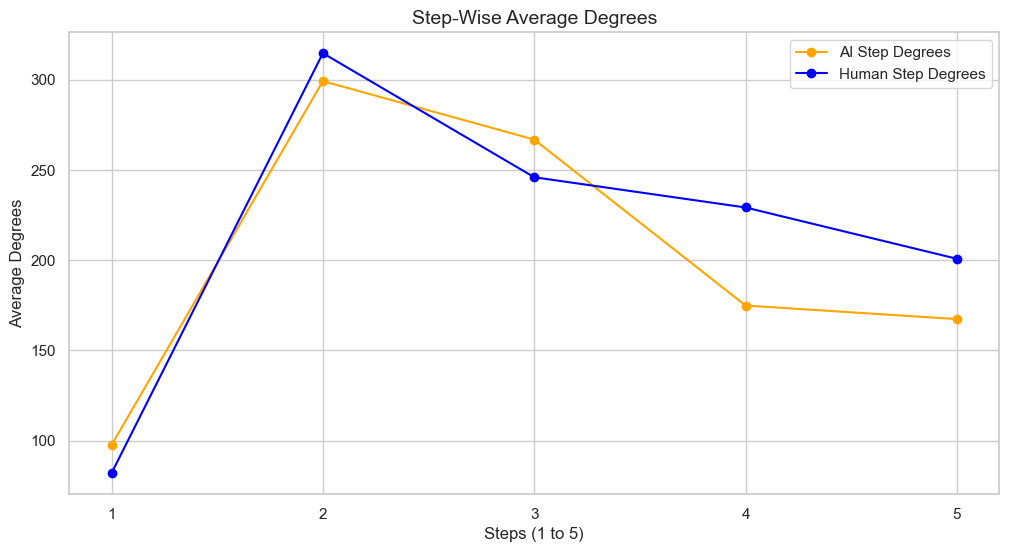

In [20]:
steps = list(range(1, degree_first_n+1))

# Filter out degrees that do not match the expected length of 9
filtered_ai_degrees = [
    degrees for key, score_lists in filtered_ai_degrees.items()
    for degrees in score_lists if len(degrees) == first_n
]
filtered_human_degrees = [
    degrees for key, score_lists in filtered_human_degrees.items()
    for degrees in score_lists if len(degrees) == first_n
]

# Convert filtered degrees to NumPy arrays for easier manipulation
ai_degrees_array = np.array(filtered_ai_degrees)
human_degrees_array = np.array(filtered_human_degrees)
human_degrees_array = human_degrees_array[~np.isnan(human_degrees_array).any(axis=1)]

# Compute average degrees for each step
ai_step_avg_degrees = ai_degrees_array.mean(axis=0)
human_step_avg_degrees = human_degrees_array.mean(axis=0)

# Plot step-wise average degrees
plt.figure(figsize=(12, 6))
plt.plot(steps, ai_step_avg_degrees, label='AI Step Degrees', marker='o', color='orange')
plt.plot(steps, human_step_avg_degrees, label='Human Step Degrees', marker='o', color='blue')

plt.title('Step-Wise Average Degrees', fontsize=14)
plt.xlabel(f'Steps (1 to {first_n})', fontsize=12)
plt.ylabel('Average Degrees', fontsize=12)
plt.xticks(steps)
plt.legend()
plt.show()